<a href="https://colab.research.google.com/github/TonyIssacJames/eva04_mar_2020_public/blob/master/Assignment_05_trial/EVA4S5F1_BruteForce_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

- we use fashionMNSIT
- same models we had before we are running using fashion MNSIT to know the effects
- we can collect data for all the model accuracy, losses for test and train

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [2]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

g_mean = torch.mean(exp_data)
g_std  = torch.std(exp_data)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((g_mean,), (g_std,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((g_mean,), (g_std,))
                                       ])


print("mean = ", g_mean)
print("std  = ", g_std)

mean =  tensor(0.1305)
std  =  tensor(0.3081)


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


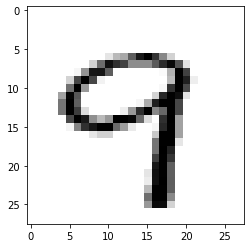

In [6]:


dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

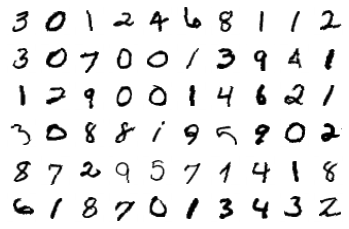

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model 01
Let's start with the model we first saw

In [0]:
class Net_01(nn.Module):
    def __init__(self):
        super(Net_01, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 02

- we are trying to get a skeletorn here

In [0]:
class Net_02(nn.Module):
    def __init__(self):
        super(Net_02, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 03

- Trim the model as much as possible, keeping the structure same

In [0]:
class Net_03(nn.Module):
    def __init__(self):
        super(Net_03, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 04

- same parameters as Model 03 (except BN added some parameters)
- increase capacity
- added Batch Normalisation

In [0]:
class Net_04(nn.Module):
    def __init__(self):
        super(Net_04, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 05

- same as Model 04 except for dropout
- same number of parameters as Model 04
- dropout is only added to two layers not to every layer

In [0]:
class Net_05(nn.Module):
    def __init__(self):
        super(Net_05, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 06

- removed FCL with GAP
- parameter reduced to 6070
- the accuracy reduces because of two reason
    - there should be a layer after GAP
    - we comparing n/w with 6070 parameters with a n/w with 10970 parameters

In [0]:
class Net_06(nn.Module):
    def __init__(self):
        super(Net_06, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 07

- the skelton is same as Model 06 but added more kernels

- the Model 06 has the following problems due to which
    - the accuracy reduces because of two reason
      - there should be a layer after GAP
      - we comparing n/w with 6070 parameters with a n/w with 10970 parameters (Fixed IT w/o chaning skeleton)

In [0]:
class Net_07(nn.Module):
    def __init__(self):
        super(Net_07, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 08

- the skelton is same as Model 06/07 but added some 1x1 kernels as transition layers

- changed position of maxpooling
- added dropout everywhere (Conv, Relu, BN, Dropout)
- added a layer after GAP

In [0]:
dropout_value = 0.1
class Net_08(nn.Module):
    def __init__(self):
        super(Net_08, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#Model 09

- Model 09 is ditto as Model 08

- while running Model 09 we just Image Augmentation

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net_09(nn.Module):
    def __init__(self):
        super(Net_09, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


## Model 01 parameters

In [0]:
Net_Array=[Net_01, Net_02, Net_03, Net_04, Net_05, Net_06, Net_07, Net_08]

In [19]:



for i, Net_X in enumerate(Net_Array):
  print("Model_0"+str(i + 1),":  Summary")
  model = Net_X().to(device)
  summary(model, input_size=(1, 28, 28))
  for n in range(5):
    print()

Model_01 :  Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-----------------

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

#train_losses = []
#test_losses = []
#train_acc = []
#test_acc = []

def train(model, device, train_loader, optimizer, epoch, loss_array, acc_array):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    loss_array.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    acc_array.append(100*correct/processed)

def test(model, device, test_loader, loss_array, acc_array):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    loss_array.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    acc_array.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [21]:


#collect all the parameters

train_losses = []
test_losses  = []
train_acc    = []
test_acc     = []


for i, Net_X in enumerate(Net_Array):
  print("Model_0"+str(i + 1),":  Training + Testing")
  model = Net_X().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 20

  train_losses.append([])
  test_losses.append([])
  train_acc.append([])
  test_acc.append([])

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_losses[i], train_acc[i])
    test(model, device, test_loader, test_losses[i], test_acc[i])

  for n in range(5):
    print()

  0%|          | 0/469 [00:00<?, ?it/s]

Model_01 :  Training + Testing
EPOCH: 0


Loss=0.08875160664319992 Batch_id=468 Accuracy=85.46: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Test Accuracy: 9828/10000 (98.28%)

EPOCH: 1


Loss=0.02263103611767292 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Test Accuracy: 9886/10000 (98.86%)

EPOCH: 2


Loss=0.07532581686973572 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Test Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.023925310000777245 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.03280811756849289 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Test Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.003894239664077759 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.06337564438581467 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 7


Loss=0.0015313029289245605 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.0030265450477600098 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.010716508142650127 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.017699742689728737 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.004936357494443655 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:14<00:00, 33.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.04767109453678131 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.001874734996818006 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.001589526771567762 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.0008232792024500668 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.0005270938272587955 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.0018929640064015985 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9947/10000 (99.47%)

EPOCH: 18


Loss=0.0006151497364044189 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.007537772413343191 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9946/10000 (99.46%)






Model_02 :  Training + Testing
EPOCH: 0


Loss=0.1429111659526825 Batch_id=468 Accuracy=65.11: 100%|██████████| 469/469 [00:12<00:00, 37.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1427, Test Accuracy: 9570/10000 (95.70%)

EPOCH: 1


Loss=0.026983698830008507 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:12<00:00, 38.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0795, Test Accuracy: 9753/10000 (97.53%)

EPOCH: 2


Loss=0.03403407335281372 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:12<00:00, 37.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Test Accuracy: 9790/10000 (97.90%)

EPOCH: 3


Loss=0.020852049812674522 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:12<00:00, 37.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Test Accuracy: 9826/10000 (98.26%)

EPOCH: 4


Loss=0.02905428223311901 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:12<00:00, 36.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Test Accuracy: 9843/10000 (98.43%)

EPOCH: 5


Loss=0.05597494915127754 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Test Accuracy: 9853/10000 (98.53%)

EPOCH: 6


Loss=0.017379486933350563 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Test Accuracy: 9881/10000 (98.81%)

EPOCH: 7


Loss=0.016019433736801147 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:12<00:00, 37.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Test Accuracy: 9862/10000 (98.62%)

EPOCH: 8


Loss=0.04835723340511322 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 37.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Test Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.0915234312415123 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:12<00:00, 37.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Test Accuracy: 9889/10000 (98.89%)

EPOCH: 10


Loss=0.014353166334331036 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:12<00:00, 36.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Test Accuracy: 9892/10000 (98.92%)

EPOCH: 11


Loss=0.03602247312664986 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 37.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Test Accuracy: 9888/10000 (98.88%)

EPOCH: 12


Loss=0.01220415998250246 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 37.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Test Accuracy: 9894/10000 (98.94%)

EPOCH: 13


Loss=0.059306394308805466 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 37.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Test Accuracy: 9888/10000 (98.88%)

EPOCH: 14


Loss=0.0045618019066751 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Test Accuracy: 9893/10000 (98.93%)

EPOCH: 15


Loss=0.00464572524651885 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Test Accuracy: 9897/10000 (98.97%)

EPOCH: 16


Loss=0.03252892568707466 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 37.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Test Accuracy: 9899/10000 (98.99%)

EPOCH: 17


Loss=0.026282981038093567 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 37.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Test Accuracy: 9867/10000 (98.67%)

EPOCH: 18


Loss=0.004145885352045298 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 37.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Test Accuracy: 9897/10000 (98.97%)

EPOCH: 19


Loss=0.02593817748129368 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 37.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Test Accuracy: 9895/10000 (98.95%)






Model_03 :  Training + Testing
EPOCH: 0


Loss=0.2922200858592987 Batch_id=468 Accuracy=49.73: 100%|██████████| 469/469 [00:12<00:00, 38.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2794, Test Accuracy: 9164/10000 (91.64%)

EPOCH: 1


Loss=0.16267840564250946 Batch_id=468 Accuracy=94.06: 100%|██████████| 469/469 [00:12<00:00, 38.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1266, Test Accuracy: 9597/10000 (95.97%)

EPOCH: 2


Loss=0.08182137459516525 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:11<00:00, 40.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0802, Test Accuracy: 9752/10000 (97.52%)

EPOCH: 3


Loss=0.1488078534603119 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:12<00:00, 37.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Test Accuracy: 9727/10000 (97.27%)

EPOCH: 4


Loss=0.06000525876879692 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:11<00:00, 39.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0770, Test Accuracy: 9778/10000 (97.78%)

EPOCH: 5


Loss=0.06632433086633682 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:11<00:00, 39.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Test Accuracy: 9844/10000 (98.44%)

EPOCH: 6


Loss=0.04110831394791603 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:12<00:00, 38.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Test Accuracy: 9833/10000 (98.33%)

EPOCH: 7


Loss=0.046505168080329895 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:11<00:00, 39.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Test Accuracy: 9846/10000 (98.46%)

EPOCH: 8


Loss=0.008493865840137005 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:11<00:00, 39.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Test Accuracy: 9865/10000 (98.65%)

EPOCH: 9


Loss=0.03168638423085213 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:12<00:00, 38.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Test Accuracy: 9864/10000 (98.64%)

EPOCH: 10


Loss=0.05637519434094429 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:11<00:00, 39.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Test Accuracy: 9852/10000 (98.52%)

EPOCH: 11


Loss=0.08270560950040817 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:11<00:00, 40.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Test Accuracy: 9879/10000 (98.79%)

EPOCH: 12


Loss=0.016330072656273842 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:11<00:00, 39.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Test Accuracy: 9879/10000 (98.79%)

EPOCH: 13


Loss=0.02892289124429226 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:11<00:00, 39.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Test Accuracy: 9879/10000 (98.79%)

EPOCH: 14


Loss=0.037241119891405106 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:11<00:00, 40.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Test Accuracy: 9891/10000 (98.91%)

EPOCH: 15


Loss=0.04007996246218681 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:11<00:00, 39.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Test Accuracy: 9870/10000 (98.70%)

EPOCH: 16


Loss=0.07154019922018051 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 39.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Test Accuracy: 9886/10000 (98.86%)

EPOCH: 17


Loss=0.006281922105699778 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:11<00:00, 39.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Test Accuracy: 9880/10000 (98.80%)

EPOCH: 18


Loss=0.005912055727094412 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:11<00:00, 39.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Test Accuracy: 9893/10000 (98.93%)

EPOCH: 19


Loss=0.012734507210552692 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 40.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Test Accuracy: 9902/10000 (99.02%)






Model_04 :  Training + Testing
EPOCH: 0


Loss=0.06450217217206955 Batch_id=468 Accuracy=93.93: 100%|██████████| 469/469 [00:12<00:00, 37.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Test Accuracy: 9849/10000 (98.49%)

EPOCH: 1


Loss=0.04546656087040901 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:12<00:00, 37.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Test Accuracy: 9853/10000 (98.53%)

EPOCH: 2


Loss=0.028443241491913795 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:12<00:00, 37.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Test Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.02962440811097622 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:12<00:00, 37.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Test Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.08028758317232132 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 36.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.043115705251693726 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 38.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Test Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.010814239270985126 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 37.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Test Accuracy: 9903/10000 (99.03%)

EPOCH: 7


Loss=0.015127971768379211 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.02789871208369732 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 37.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.004295607563108206 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.004209935665130615 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:12<00:00, 36.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.004467219114303589 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.009739468805491924 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:12<00:00, 37.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.0013204365968704224 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 36.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.014671951532363892 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:12<00:00, 37.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.005071451421827078 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:12<00:00, 37.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.011135290376842022 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:12<00:00, 37.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Test Accuracy: 9907/10000 (99.07%)

EPOCH: 17


Loss=0.008575499057769775 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.025732725858688354 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:12<00:00, 36.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.00153403973672539 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:12<00:00, 37.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Test Accuracy: 9932/10000 (99.32%)






Model_05 :  Training + Testing
EPOCH: 0


Loss=0.045042749494314194 Batch_id=468 Accuracy=93.02: 100%|██████████| 469/469 [00:12<00:00, 36.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1185, Test Accuracy: 9631/10000 (96.31%)

EPOCH: 1


Loss=0.05605484917759895 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1024, Test Accuracy: 9673/10000 (96.73%)

EPOCH: 2


Loss=0.09042337536811829 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0621, Test Accuracy: 9798/10000 (97.98%)

EPOCH: 3


Loss=0.021831104531884193 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 36.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Test Accuracy: 9864/10000 (98.64%)

EPOCH: 4


Loss=0.20086650550365448 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:12<00:00, 36.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Test Accuracy: 9871/10000 (98.71%)

EPOCH: 5


Loss=0.005180656909942627 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:12<00:00, 36.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Test Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.059469182044267654 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Test Accuracy: 9891/10000 (98.91%)

EPOCH: 7


Loss=0.0074181160889565945 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Test Accuracy: 9861/10000 (98.61%)

EPOCH: 8


Loss=0.02262517251074314 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:12<00:00, 36.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Test Accuracy: 9885/10000 (98.85%)

EPOCH: 9


Loss=0.05199025943875313 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 36.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Test Accuracy: 9865/10000 (98.65%)

EPOCH: 10


Loss=0.06366798281669617 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Test Accuracy: 9856/10000 (98.56%)

EPOCH: 11


Loss=0.023128068074584007 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Test Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=0.08661077171564102 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Test Accuracy: 9856/10000 (98.56%)

EPOCH: 13


Loss=0.03501565381884575 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 36.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Test Accuracy: 9877/10000 (98.77%)

EPOCH: 14


Loss=0.035572588443756104 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Test Accuracy: 9841/10000 (98.41%)

EPOCH: 15


Loss=0.0881102979183197 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Test Accuracy: 9900/10000 (99.00%)

EPOCH: 16


Loss=0.016423290595412254 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 36.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Test Accuracy: 9900/10000 (99.00%)

EPOCH: 17


Loss=0.014910568483173847 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Test Accuracy: 9894/10000 (98.94%)

EPOCH: 18


Loss=0.008168254978954792 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Test Accuracy: 9901/10000 (99.01%)

EPOCH: 19


Loss=0.006159598473459482 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 35.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Test Accuracy: 9910/10000 (99.10%)






Model_06 :  Training + Testing
EPOCH: 0


Loss=0.34632933139801025 Batch_id=468 Accuracy=81.11: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4642, Test Accuracy: 9126/10000 (91.26%)

EPOCH: 1


Loss=0.2119860053062439 Batch_id=468 Accuracy=95.41: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3164, Test Accuracy: 9236/10000 (92.36%)

EPOCH: 2


Loss=0.2085559219121933 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:12<00:00, 37.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3130, Test Accuracy: 9120/10000 (91.20%)

EPOCH: 3


Loss=0.1493847370147705 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:12<00:00, 37.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2305, Test Accuracy: 9376/10000 (93.76%)

EPOCH: 4


Loss=0.08100204914808273 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:12<00:00, 37.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2122, Test Accuracy: 9427/10000 (94.27%)

EPOCH: 5


Loss=0.07236236333847046 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:12<00:00, 37.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1914, Test Accuracy: 9478/10000 (94.78%)

EPOCH: 6


Loss=0.07231602817773819 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:12<00:00, 37.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1960, Test Accuracy: 9470/10000 (94.70%)

EPOCH: 7


Loss=0.07366160303354263 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:12<00:00, 37.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1368, Test Accuracy: 9643/10000 (96.43%)

EPOCH: 8


Loss=0.07552442699670792 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:12<00:00, 37.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1884, Test Accuracy: 9436/10000 (94.36%)

EPOCH: 9


Loss=0.07972774654626846 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:12<00:00, 37.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1678, Test Accuracy: 9493/10000 (94.93%)

EPOCH: 10


Loss=0.08553993701934814 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:12<00:00, 38.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1227, Test Accuracy: 9668/10000 (96.68%)

EPOCH: 11


Loss=0.06292122602462769 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:12<00:00, 38.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Test Accuracy: 9825/10000 (98.25%)

EPOCH: 12


Loss=0.06367290765047073 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0960, Test Accuracy: 9736/10000 (97.36%)

EPOCH: 13


Loss=0.08991970866918564 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:12<00:00, 37.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1163, Test Accuracy: 9676/10000 (96.76%)

EPOCH: 14


Loss=0.07738696038722992 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:12<00:00, 37.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0993, Test Accuracy: 9711/10000 (97.11%)

EPOCH: 15


Loss=0.04816296324133873 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:12<00:00, 36.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1218, Test Accuracy: 9652/10000 (96.52%)

EPOCH: 16


Loss=0.07196345925331116 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:12<00:00, 37.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0955, Test Accuracy: 9729/10000 (97.29%)

EPOCH: 17


Loss=0.12333134561777115 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:12<00:00, 37.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0842, Test Accuracy: 9766/10000 (97.66%)

EPOCH: 18


Loss=0.019551744684576988 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:12<00:00, 38.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Test Accuracy: 9829/10000 (98.29%)

EPOCH: 19


Loss=0.09522336721420288 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1016, Test Accuracy: 9712/10000 (97.12%)






Model_07 :  Training + Testing
EPOCH: 0


Loss=0.13256442546844482 Batch_id=468 Accuracy=84.45: 100%|██████████| 469/469 [00:12<00:00, 37.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1491, Test Accuracy: 9593/10000 (95.93%)

EPOCH: 1


Loss=0.09605290740728378 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:12<00:00, 37.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Test Accuracy: 9805/10000 (98.05%)

EPOCH: 2


Loss=0.10102049261331558 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:12<00:00, 37.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Test Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.06742331385612488 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:12<00:00, 37.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Test Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.03972649201750755 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:12<00:00, 37.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.03340466320514679 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:12<00:00, 38.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Test Accuracy: 9880/10000 (98.80%)

EPOCH: 6


Loss=0.02795625664293766 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:12<00:00, 36.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Test Accuracy: 9903/10000 (99.03%)

EPOCH: 7


Loss=0.013629421591758728 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:12<00:00, 36.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Test Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.00884641706943512 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 35.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.006107836961746216 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:12<00:00, 36.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.05517623946070671 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:12<00:00, 37.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Test Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.029064267873764038 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.022825434803962708 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 37.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.03931696340441704 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 38.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.02578585408627987 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 37.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 15


Loss=0.027465952560305595 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 38.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 16


Loss=0.058116331696510315 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 38.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 17


Loss=0.007721498608589172 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 38.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.02608601190149784 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 37.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 19


Loss=0.02217019535601139 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 37.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Test Accuracy: 9898/10000 (98.98%)






Model_08 :  Training + Testing
EPOCH: 0


Loss=0.09258812665939331 Batch_id=468 Accuracy=87.64: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1785, Test Accuracy: 9467/10000 (94.67%)

EPOCH: 1


Loss=0.027839599177241325 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:12<00:00, 37.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Test Accuracy: 9825/10000 (98.25%)

EPOCH: 2


Loss=0.12802235782146454 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:12<00:00, 37.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Test Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.048531029373407364 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:12<00:00, 37.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Test Accuracy: 9864/10000 (98.64%)

EPOCH: 4


Loss=0.02568892575800419 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:12<00:00, 37.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.010121400468051434 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:12<00:00, 37.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Test Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.08050066977739334 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.08172208070755005 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:12<00:00, 37.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.018440479412674904 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 37.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.013290529139339924 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.013491610996425152 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:12<00:00, 37.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.02041848935186863 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.021916339173913002 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 37.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.014304123818874359 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.023993590846657753 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 37.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 15


Loss=0.002988835098221898 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 37.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.039345189929008484 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 37.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Loss=0.00849895179271698 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.03441264107823372 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 37.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.06493490189313889 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]



Test set: Average loss: 0.0179, Test Accuracy: 9947/10000 (99.47%)








In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_multiple(lines, labels):
  fig=plt.figure(figsize=(15,10))
  ax=fig.add_subplot(111)

  if len(lines) == len(labels):
    for line, label in zip(lines, labels):
      plt.plot(range(1, len(line)+1), line, label=label)

    plt.grid()
    plt.legend(loc=2)
    plt.show()
  else:
    print("Cannot Draw Graph, error")

In [0]:
labels = ['Model_01', 'Model_02', 'Model_03', 'Model_04', 'Model_05', 'Model_06', 'Model_07', 'Model_08']

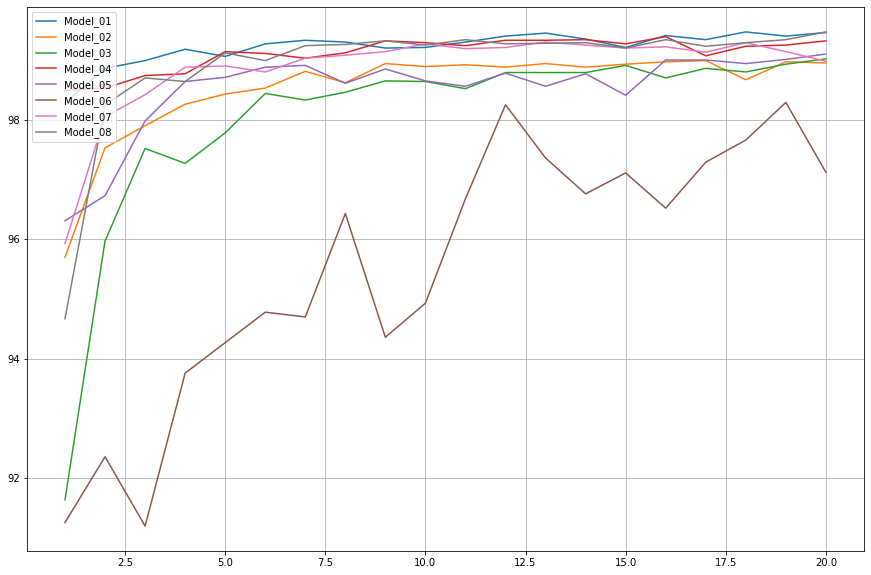

In [26]:
plot_multiple(test_acc, labels)

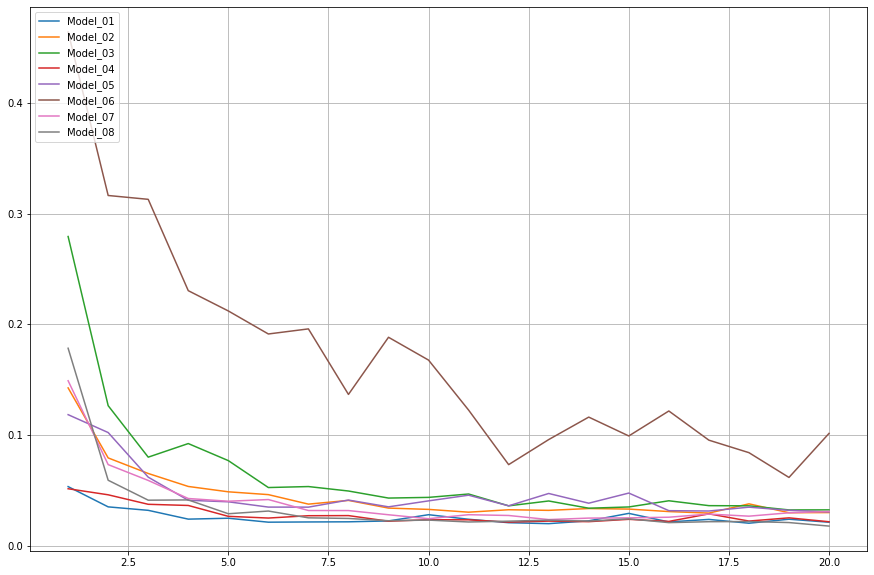

In [27]:
plot_multiple(test_losses, labels)

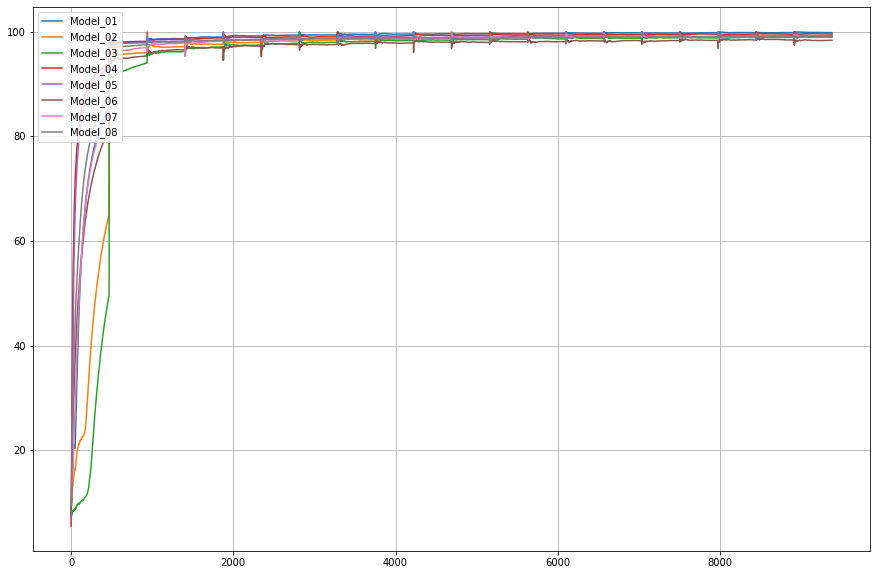

In [28]:
plot_multiple(train_acc, labels)

## let's write some code to try brute force method to find a mode under 10K


In [34]:

  
model = Net_09().to(device)
sum = summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [37]:
import sys

model.parameters()

<generator object Module.parameters at 0x7f2f53fd4f10>

In [0]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [39]:
get_n_params(model)

13808

# Make the model parameters configurable

  - so we can do a brute force check

In [0]:
import torch.nn.functional as F
dropout_value = 0.1

ch_list = [16, 32, 10, 16, 16, 16, 16]

class Net_10(nn.Module):
    def __init__(self, ch_list):
        super(Net_10, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=ch_list[0], kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(ch_list[0]),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=ch_list[0], out_channels=ch_list[1], kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(ch_list[1]),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=ch_list[1], out_channels=ch_list[2], kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=ch_list[2], out_channels=ch_list[3], kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(ch_list[3]),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=ch_list[3], out_channels=ch_list[4], kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(ch_list[4]),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=ch_list[4], out_channels=ch_list[5], kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(ch_list[5]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=ch_list[5], out_channels=ch_list[6], kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(ch_list[6]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=ch_list[6], out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [43]:
model = Net_10(ch_list).to(device)
sum = summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [66]:
import copy
import numpy as np
from itertools import product

org_ch_list = [16, 32, 10, 16, 16, 16, 16]



L1_EPOCHS = 10
L2_EPOCHS = 10

potential_ch_list = []

for ch1, ch2, ch3, ch4, ch5, ch6, ch7 in product(range(-6, 7, 2),
                                                 range(0, -13, -2), 
                                                 range(0, 7, 2),
                                                 range(-6, 7, 2),
                                                 range(-6, 7, 2),
                                                 range(-6, 7, 2),
                                                 range(-6, 7, 2)):

              ch_list = copy.copy(org_ch_list)
              ch_list = list(np.array(ch_list) + np.array([ch1, ch2, ch3, ch4, ch5, ch6, ch7]))

              print("ch_list: ", ch_list)

              model = Net_10(ch_list).to(device)

              if get_n_params(model) <= 10000: #if parameters are less than 10K then only train

                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

                
                train_losses = []
                test_losses  = []
                train_acc    = []
                test_acc     = []

                for epoch in range(L1_EPOCHS):
                  train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
                  test(model, device, test_loader, test_losses, test_acc)

                  test_acc_np = np.array(test_acc)
                  acc_cnt = test_acc_np[ test_acc_np> 99.28].size

                  if(acc_cnt > 0):
                    potential_ch_list.append([ch1, ch2, ch3, ch4, ch5, ch6, ch7])
                    print("Found CH list: ",[ch1, ch2, ch3, ch4, ch5, ch6, ch7])


  0%|          | 0/469 [00:00<?, ?it/s]

ch_list:  [10, 32, 10, 10, 10, 10, 10]


Loss=0.1661694049835205 Batch_id=468 Accuracy=80.30: 100%|██████████| 469/469 [00:12<00:00, 36.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0972, Test Accuracy: 9750/10000 (97.50%)



Loss=0.140473410487175 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:12<00:00, 36.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Test Accuracy: 9842/10000 (98.42%)



Loss=0.05994058772921562 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Test Accuracy: 9886/10000 (98.86%)



Loss=0.04068725183606148 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Test Accuracy: 9884/10000 (98.84%)



Loss=0.0648437887430191 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:12<00:00, 36.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Test Accuracy: 9905/10000 (99.05%)



Loss=0.03328023850917816 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Test Accuracy: 9892/10000 (98.92%)



Loss=0.011128723621368408 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Test Accuracy: 9899/10000 (98.99%)



Loss=0.2299552708864212 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9921/10000 (99.21%)



Loss=0.07887649536132812 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Test Accuracy: 9901/10000 (99.01%)



Loss=0.03267744556069374 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test Accuracy: 9909/10000 (99.09%)

ch_list:  [10, 32, 10, 10, 10, 10, 12]


Loss=0.18307872116565704 Batch_id=468 Accuracy=82.64: 100%|██████████| 469/469 [00:13<00:00, 35.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1111, Test Accuracy: 9710/10000 (97.10%)



Loss=0.08819947391748428 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0750, Test Accuracy: 9762/10000 (97.62%)



Loss=0.04785928502678871 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Test Accuracy: 9846/10000 (98.46%)



Loss=0.11154478788375854 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Test Accuracy: 9848/10000 (98.48%)



Loss=0.02654826082289219 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Test Accuracy: 9870/10000 (98.70%)



Loss=0.11347919702529907 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Test Accuracy: 9876/10000 (98.76%)



Loss=0.08845136314630508 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Test Accuracy: 9894/10000 (98.94%)



Loss=0.03660564124584198 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 36.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Test Accuracy: 9880/10000 (98.80%)



Loss=0.03299476206302643 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Test Accuracy: 9896/10000 (98.96%)



Loss=0.018481796607375145 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Test Accuracy: 9906/10000 (99.06%)

ch_list:  [10, 32, 10, 10, 10, 10, 14]


Loss=0.23977170884609222 Batch_id=468 Accuracy=80.62: 100%|██████████| 469/469 [00:13<00:00, 35.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0898, Test Accuracy: 9761/10000 (97.61%)



Loss=0.09194964915513992 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Test Accuracy: 9839/10000 (98.39%)



Loss=0.14649824798107147 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Test Accuracy: 9884/10000 (98.84%)



Loss=0.09292751550674438 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Test Accuracy: 9874/10000 (98.74%)



Loss=0.014324113726615906 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Test Accuracy: 9887/10000 (98.87%)



Loss=0.029742902144789696 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Test Accuracy: 9913/10000 (99.13%)



Loss=0.15565486252307892 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Test Accuracy: 9909/10000 (99.09%)



Loss=0.01495699118822813 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Test Accuracy: 9901/10000 (99.01%)



Loss=0.1390153020620346 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Test Accuracy: 9909/10000 (99.09%)



Loss=0.05942196771502495 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Test Accuracy: 9910/10000 (99.10%)

ch_list:  [10, 32, 10, 10, 10, 10, 16]


Loss=0.16641363501548767 Batch_id=468 Accuracy=82.98: 100%|██████████| 469/469 [00:13<00:00, 34.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1054, Test Accuracy: 9737/10000 (97.37%)



Loss=0.052183885127305984 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:13<00:00, 35.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Test Accuracy: 9803/10000 (98.03%)



Loss=0.03819049149751663 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0835, Test Accuracy: 9758/10000 (97.58%)



Loss=0.11037131398916245 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:13<00:00, 35.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Test Accuracy: 9842/10000 (98.42%)



Loss=0.05723552033305168 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Test Accuracy: 9872/10000 (98.72%)



Loss=0.06602422893047333 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 34.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Test Accuracy: 9876/10000 (98.76%)



Loss=0.061898525804281235 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Test Accuracy: 9895/10000 (98.95%)



Loss=0.08922412246465683 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Test Accuracy: 9895/10000 (98.95%)



Loss=0.059845536947250366 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Test Accuracy: 9905/10000 (99.05%)



Loss=0.03139708936214447 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 35.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Test Accuracy: 9913/10000 (99.13%)

ch_list:  [10, 32, 10, 10, 10, 10, 18]


Loss=0.1765541434288025 Batch_id=468 Accuracy=84.38: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2180, Test Accuracy: 9366/10000 (93.66%)



Loss=0.08417198061943054 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0646, Test Accuracy: 9808/10000 (98.08%)



Loss=0.08284098654985428 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Test Accuracy: 9858/10000 (98.58%)



Loss=0.15786021947860718 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Test Accuracy: 9862/10000 (98.62%)



Loss=0.017191976308822632 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 35.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Test Accuracy: 9885/10000 (98.85%)



Loss=0.06312110275030136 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Test Accuracy: 9881/10000 (98.81%)



Loss=0.026612116023898125 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Test Accuracy: 9882/10000 (98.82%)



Loss=0.0625760480761528 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Test Accuracy: 9899/10000 (98.99%)



Loss=0.08153664320707321 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 35.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Test Accuracy: 9903/10000 (99.03%)



Loss=0.04057798907160759 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Test Accuracy: 9908/10000 (99.08%)

ch_list:  [10, 32, 10, 10, 10, 10, 20]


Loss=0.22332845628261566 Batch_id=468 Accuracy=85.15: 100%|██████████| 469/469 [00:13<00:00, 34.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0926, Test Accuracy: 9739/10000 (97.39%)



Loss=0.11211905628442764 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Test Accuracy: 9858/10000 (98.58%)



Loss=0.0285198912024498 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Test Accuracy: 9863/10000 (98.63%)



Loss=0.03857945278286934 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Test Accuracy: 9887/10000 (98.87%)



Loss=0.03294745087623596 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Test Accuracy: 9876/10000 (98.76%)



Loss=0.027796203270554543 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Test Accuracy: 9904/10000 (99.04%)



Loss=0.03572116419672966 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Test Accuracy: 9917/10000 (99.17%)



Loss=0.07158753275871277 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Test Accuracy: 9919/10000 (99.19%)



Loss=0.07862953841686249 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test Accuracy: 9909/10000 (99.09%)



Loss=0.01667105406522751 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Test Accuracy: 9918/10000 (99.18%)

ch_list:  [10, 32, 10, 10, 10, 10, 22]


Loss=0.1353132724761963 Batch_id=468 Accuracy=83.96: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Test Accuracy: 9777/10000 (97.77%)



Loss=0.10450329631567001 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Test Accuracy: 9837/10000 (98.37%)



Loss=0.04349326714873314 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Test Accuracy: 9826/10000 (98.26%)



Loss=0.033694371581077576 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Test Accuracy: 9869/10000 (98.69%)



Loss=0.036334384232759476 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Test Accuracy: 9881/10000 (98.81%)



Loss=0.08199337869882584 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:13<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Test Accuracy: 9896/10000 (98.96%)



Loss=0.08083857595920563 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Test Accuracy: 9902/10000 (99.02%)



Loss=0.025112204253673553 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test Accuracy: 9918/10000 (99.18%)



Loss=0.04924916848540306 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Test Accuracy: 9908/10000 (99.08%)



Loss=0.04557279124855995 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Test Accuracy: 9918/10000 (99.18%)

ch_list:  [10, 32, 10, 10, 10, 12, 10]


Loss=0.22852332890033722 Batch_id=468 Accuracy=84.17: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0803, Test Accuracy: 9779/10000 (97.79%)



Loss=0.11171194165945053 Batch_id=468 Accuracy=96.87: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0683, Test Accuracy: 9797/10000 (97.97%)



Loss=0.09790680557489395 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Test Accuracy: 9881/10000 (98.81%)



Loss=0.07639343291521072 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Test Accuracy: 9897/10000 (98.97%)



Loss=0.040897924453020096 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test Accuracy: 9921/10000 (99.21%)



Loss=0.011872942559421062 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Test Accuracy: 9909/10000 (99.09%)



Loss=0.03970545902848244 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Test Accuracy: 9917/10000 (99.17%)



Loss=0.033953603357076645 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Test Accuracy: 9905/10000 (99.05%)



Loss=0.019361749291419983 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 35.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9918/10000 (99.18%)



Loss=0.06092044711112976 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test Accuracy: 9912/10000 (99.12%)

ch_list:  [10, 32, 10, 10, 10, 12, 12]


Loss=0.1475205272436142 Batch_id=468 Accuracy=85.14: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1043, Test Accuracy: 9711/10000 (97.11%)



Loss=0.20821642875671387 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Test Accuracy: 9814/10000 (98.14%)



Loss=0.03403672203421593 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0772, Test Accuracy: 9758/10000 (97.58%)



Loss=0.08541947603225708 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Test Accuracy: 9854/10000 (98.54%)



Loss=0.06450463831424713 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Test Accuracy: 9846/10000 (98.46%)



Loss=0.09186813980340958 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Test Accuracy: 9889/10000 (98.89%)



Loss=0.025554746389389038 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Test Accuracy: 9879/10000 (98.79%)



Loss=0.05795564875006676 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Test Accuracy: 9903/10000 (99.03%)



Loss=0.03799047693610191 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Test Accuracy: 9896/10000 (98.96%)



Loss=0.03487608954310417 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:13<00:00, 34.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Test Accuracy: 9909/10000 (99.09%)

ch_list:  [10, 32, 10, 10, 10, 12, 14]


Loss=0.12243453413248062 Batch_id=468 Accuracy=84.24: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0927, Test Accuracy: 9745/10000 (97.45%)



Loss=0.0780504122376442 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Test Accuracy: 9822/10000 (98.22%)



Loss=0.03291309252381325 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Test Accuracy: 9825/10000 (98.25%)



Loss=0.06162941828370094 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Test Accuracy: 9894/10000 (98.94%)



Loss=0.04624383524060249 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Test Accuracy: 9897/10000 (98.97%)



Loss=0.12355301529169083 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Test Accuracy: 9912/10000 (99.12%)



Loss=0.018294164910912514 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Test Accuracy: 9907/10000 (99.07%)



Loss=0.05708351358771324 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Test Accuracy: 9907/10000 (99.07%)



Loss=0.017722666263580322 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Test Accuracy: 9914/10000 (99.14%)



Loss=0.02773848921060562 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test Accuracy: 9909/10000 (99.09%)

ch_list:  [10, 32, 10, 10, 10, 12, 16]


Loss=0.16595196723937988 Batch_id=468 Accuracy=85.24: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0803, Test Accuracy: 9788/10000 (97.88%)



Loss=0.0705529972910881 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Test Accuracy: 9835/10000 (98.35%)



Loss=0.06193895637989044 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Test Accuracy: 9767/10000 (97.67%)



Loss=0.06885511428117752 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Test Accuracy: 9895/10000 (98.95%)



Loss=0.03867121413350105 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Test Accuracy: 9903/10000 (99.03%)



Loss=0.062258899211883545 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Test Accuracy: 9894/10000 (98.94%)



Loss=0.018772566691040993 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Test Accuracy: 9900/10000 (99.00%)



Loss=0.039347950369119644 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Test Accuracy: 9909/10000 (99.09%)



Loss=0.056726936250925064 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Test Accuracy: 9876/10000 (98.76%)



Loss=0.08042974025011063 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Test Accuracy: 9928/10000 (99.28%)

ch_list:  [10, 32, 10, 10, 10, 12, 18]


Loss=0.16849370300769806 Batch_id=468 Accuracy=84.91: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0943, Test Accuracy: 9731/10000 (97.31%)



Loss=0.08038438111543655 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Test Accuracy: 9815/10000 (98.15%)



Loss=0.06271161884069443 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Test Accuracy: 9868/10000 (98.68%)



Loss=0.07289696484804153 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Test Accuracy: 9884/10000 (98.84%)



Loss=0.0639544352889061 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Test Accuracy: 9900/10000 (99.00%)



Loss=0.02845931239426136 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Test Accuracy: 9866/10000 (98.66%)



Loss=0.019297560676932335 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Test Accuracy: 9901/10000 (99.01%)



Loss=0.016443440690636635 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Test Accuracy: 9911/10000 (99.11%)



Loss=0.07501386851072311 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Test Accuracy: 9924/10000 (99.24%)



Loss=0.027819549664855003 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 34.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Test Accuracy: 9927/10000 (99.27%)

ch_list:  [10, 32, 10, 10, 10, 12, 20]


Loss=0.22690898180007935 Batch_id=468 Accuracy=85.92: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0759, Test Accuracy: 9778/10000 (97.78%)



Loss=0.14369599521160126 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Test Accuracy: 9839/10000 (98.39%)



Loss=0.035723503679037094 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Test Accuracy: 9850/10000 (98.50%)



Loss=0.06294438242912292 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Test Accuracy: 9883/10000 (98.83%)



Loss=0.03549516946077347 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Test Accuracy: 9857/10000 (98.57%)



Loss=0.07570310682058334 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Test Accuracy: 9911/10000 (99.11%)



Loss=0.17638300359249115 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Test Accuracy: 9901/10000 (99.01%)



Loss=0.0680554062128067 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Test Accuracy: 9902/10000 (99.02%)



Loss=0.03880690038204193 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Test Accuracy: 9915/10000 (99.15%)



Loss=0.06256606429815292 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9906/10000 (99.06%)

ch_list:  [10, 32, 10, 10, 10, 12, 22]


Loss=0.09546360373497009 Batch_id=468 Accuracy=85.72: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1251, Test Accuracy: 9644/10000 (96.44%)



Loss=0.05968499556183815 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Test Accuracy: 9807/10000 (98.07%)



Loss=0.07534004002809525 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Test Accuracy: 9837/10000 (98.37%)



Loss=0.1525270938873291 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Test Accuracy: 9860/10000 (98.60%)



Loss=0.04177139326930046 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Test Accuracy: 9879/10000 (98.79%)



Loss=0.045637041330337524 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:13<00:00, 34.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Test Accuracy: 9891/10000 (98.91%)



Loss=0.058096859604120255 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Test Accuracy: 9885/10000 (98.85%)



Loss=0.027597807347774506 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Test Accuracy: 9915/10000 (99.15%)



Loss=0.07023052126169205 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Test Accuracy: 9897/10000 (98.97%)



Loss=0.013215367682278156 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Test Accuracy: 9897/10000 (98.97%)

ch_list:  [10, 32, 10, 10, 10, 14, 10]


Loss=0.1504344791173935 Batch_id=468 Accuracy=83.76: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1817, Test Accuracy: 9499/10000 (94.99%)



Loss=0.10130533576011658 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0984, Test Accuracy: 9707/10000 (97.07%)



Loss=0.04495398327708244 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Test Accuracy: 9837/10000 (98.37%)



Loss=0.04419174790382385 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9880/10000 (98.80%)



Loss=0.05735616758465767 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Test Accuracy: 9845/10000 (98.45%)



Loss=0.020312242209911346 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Test Accuracy: 9900/10000 (99.00%)



Loss=0.03972694277763367 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Test Accuracy: 9914/10000 (99.14%)



Loss=0.07576967775821686 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 35.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Test Accuracy: 9910/10000 (99.10%)



Loss=0.06201983615756035 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Test Accuracy: 9910/10000 (99.10%)



Loss=0.10470221191644669 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Test Accuracy: 9873/10000 (98.73%)

ch_list:  [10, 32, 10, 10, 10, 14, 12]


Loss=0.2075567990541458 Batch_id=468 Accuracy=84.48: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1110, Test Accuracy: 9693/10000 (96.93%)



Loss=0.11512172967195511 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Test Accuracy: 9785/10000 (97.85%)



Loss=0.10718084126710892 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Test Accuracy: 9851/10000 (98.51%)



Loss=0.06067628040909767 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Test Accuracy: 9871/10000 (98.71%)



Loss=0.08537475019693375 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Test Accuracy: 9904/10000 (99.04%)



Loss=0.0673237070441246 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Test Accuracy: 9910/10000 (99.10%)



Loss=0.03821827471256256 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Test Accuracy: 9871/10000 (98.71%)



Loss=0.012695620767772198 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Test Accuracy: 9919/10000 (99.19%)



Loss=0.03040059469640255 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Test Accuracy: 9898/10000 (98.98%)



Loss=0.02231154404580593 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Test Accuracy: 9902/10000 (99.02%)

ch_list:  [10, 32, 10, 10, 10, 14, 14]


Loss=0.1165703609585762 Batch_id=468 Accuracy=84.55: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0834, Test Accuracy: 9769/10000 (97.69%)



Loss=0.09819477796554565 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Test Accuracy: 9841/10000 (98.41%)



Loss=0.12268370389938354 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Test Accuracy: 9887/10000 (98.87%)



Loss=0.06961602717638016 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Test Accuracy: 9859/10000 (98.59%)



Loss=0.06479605287313461 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Test Accuracy: 9881/10000 (98.81%)



Loss=0.037524644285440445 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Test Accuracy: 9894/10000 (98.94%)



Loss=0.1364908665418625 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Test Accuracy: 9906/10000 (99.06%)



Loss=0.06714586168527603 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Test Accuracy: 9895/10000 (98.95%)



Loss=0.07390499860048294 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 34.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Test Accuracy: 9919/10000 (99.19%)



Loss=0.04420654475688934 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Test Accuracy: 9901/10000 (99.01%)

ch_list:  [10, 32, 10, 10, 10, 14, 16]


Loss=0.1417904943227768 Batch_id=468 Accuracy=84.45: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1142, Test Accuracy: 9668/10000 (96.68%)



Loss=0.058470431715250015 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Test Accuracy: 9844/10000 (98.44%)



Loss=0.04360029101371765 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Test Accuracy: 9863/10000 (98.63%)



Loss=0.07525770366191864 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Test Accuracy: 9874/10000 (98.74%)



Loss=0.046455368399620056 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Test Accuracy: 9887/10000 (98.87%)



Loss=0.036035362631082535 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Test Accuracy: 9901/10000 (99.01%)



Loss=0.00971172284334898 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Test Accuracy: 9887/10000 (98.87%)



Loss=0.07058504968881607 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Test Accuracy: 9887/10000 (98.87%)



Loss=0.03388315066695213 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Test Accuracy: 9919/10000 (99.19%)



Loss=0.024531101807951927 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Test Accuracy: 9889/10000 (98.89%)

ch_list:  [10, 32, 10, 10, 10, 14, 18]


Loss=0.26427197456359863 Batch_id=468 Accuracy=83.88: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1411, Test Accuracy: 9592/10000 (95.92%)



Loss=0.05781283602118492 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Test Accuracy: 9755/10000 (97.55%)



Loss=0.061058998107910156 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Test Accuracy: 9826/10000 (98.26%)



Loss=0.031259164214134216 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Test Accuracy: 9851/10000 (98.51%)



Loss=0.01735805533826351 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Test Accuracy: 9884/10000 (98.84%)



Loss=0.05417279899120331 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Test Accuracy: 9899/10000 (98.99%)



Loss=0.017337171360850334 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Test Accuracy: 9887/10000 (98.87%)



Loss=0.055817294865846634 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Test Accuracy: 9897/10000 (98.97%)



Loss=0.03946607932448387 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Test Accuracy: 9905/10000 (99.05%)



Loss=0.03218058869242668 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Test Accuracy: 9924/10000 (99.24%)

ch_list:  [10, 32, 10, 10, 10, 14, 20]


Loss=0.19772255420684814 Batch_id=468 Accuracy=85.09: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0998, Test Accuracy: 9727/10000 (97.27%)



Loss=0.10643607378005981 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Test Accuracy: 9855/10000 (98.55%)



Loss=0.03582656383514404 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Test Accuracy: 9852/10000 (98.52%)



Loss=0.08267644792795181 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Test Accuracy: 9903/10000 (99.03%)



Loss=0.10964388400316238 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Test Accuracy: 9894/10000 (98.94%)



Loss=0.05739116296172142 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Test Accuracy: 9903/10000 (99.03%)



Loss=0.04204418137669563 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Test Accuracy: 9907/10000 (99.07%)



Loss=0.03680749610066414 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Test Accuracy: 9918/10000 (99.18%)



Loss=0.04326288402080536 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Test Accuracy: 9924/10000 (99.24%)



Loss=0.04113722965121269 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9916/10000 (99.16%)

ch_list:  [10, 32, 10, 10, 10, 14, 22]


Loss=0.09662523120641708 Batch_id=468 Accuracy=86.30: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1031, Test Accuracy: 9698/10000 (96.98%)



Loss=0.07496625930070877 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0575, Test Accuracy: 9823/10000 (98.23%)



Loss=0.07015179842710495 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Test Accuracy: 9862/10000 (98.62%)



Loss=0.01911608874797821 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Test Accuracy: 9875/10000 (98.75%)



Loss=0.016298526898026466 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Test Accuracy: 9871/10000 (98.71%)



Loss=0.028329836204648018 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Test Accuracy: 9888/10000 (98.88%)



Loss=0.04538324102759361 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Test Accuracy: 9899/10000 (98.99%)



Loss=0.03573499247431755 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Test Accuracy: 9902/10000 (99.02%)



Loss=0.025305571034550667 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Test Accuracy: 9899/10000 (98.99%)



Loss=0.025027403607964516 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Test Accuracy: 9908/10000 (99.08%)

ch_list:  [10, 32, 10, 10, 10, 16, 10]


Loss=0.1795007586479187 Batch_id=468 Accuracy=83.63: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0820, Test Accuracy: 9799/10000 (97.99%)



Loss=0.048765670508146286 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Test Accuracy: 9805/10000 (98.05%)



Loss=0.15864121913909912 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Test Accuracy: 9850/10000 (98.50%)



Loss=0.2167590707540512 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Test Accuracy: 9834/10000 (98.34%)



Loss=0.022399568930268288 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Test Accuracy: 9898/10000 (98.98%)



Loss=0.022679083049297333 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Test Accuracy: 9885/10000 (98.85%)



Loss=0.04654683545231819 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Test Accuracy: 9903/10000 (99.03%)



Loss=0.011403103359043598 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Test Accuracy: 9896/10000 (98.96%)



Loss=0.09942195564508438 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Test Accuracy: 9910/10000 (99.10%)



Loss=0.13301610946655273 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Test Accuracy: 9909/10000 (99.09%)

ch_list:  [10, 32, 10, 10, 10, 16, 12]


Loss=0.16967613995075226 Batch_id=468 Accuracy=83.77: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1064, Test Accuracy: 9697/10000 (96.97%)



Loss=0.10723316669464111 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Test Accuracy: 9828/10000 (98.28%)



Loss=0.0674111619591713 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Test Accuracy: 9875/10000 (98.75%)



Loss=0.01390354335308075 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Test Accuracy: 9905/10000 (99.05%)



Loss=0.06819143891334534 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Test Accuracy: 9895/10000 (98.95%)



Loss=0.007898852229118347 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Test Accuracy: 9900/10000 (99.00%)



Loss=0.05759568139910698 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Test Accuracy: 9934/10000 (99.34%)

Found CH list:  [-6, 0, 0, -6, -6, 0, -4]


Loss=0.07651468366384506 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Test Accuracy: 9909/10000 (99.09%)

Found CH list:  [-6, 0, 0, -6, -6, 0, -4]


Loss=0.050422027707099915 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test Accuracy: 9911/10000 (99.11%)

Found CH list:  [-6, 0, 0, -6, -6, 0, -4]


Loss=0.15972979366779327 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Test Accuracy: 9929/10000 (99.29%)

Found CH list:  [-6, 0, 0, -6, -6, 0, -4]
ch_list:  [10, 32, 10, 10, 10, 16, 14]


Loss=0.12783925235271454 Batch_id=468 Accuracy=83.31: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0800, Test Accuracy: 9784/10000 (97.84%)



Loss=0.11295970529317856 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Test Accuracy: 9827/10000 (98.27%)



Loss=0.05283692479133606 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Test Accuracy: 9876/10000 (98.76%)



Loss=0.13998135924339294 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Test Accuracy: 9899/10000 (98.99%)



Loss=0.038130056113004684 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Test Accuracy: 9900/10000 (99.00%)



Loss=0.026579877361655235 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Test Accuracy: 9890/10000 (98.90%)



Loss=0.0281656663864851 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Test Accuracy: 9920/10000 (99.20%)



Loss=0.03494110330939293 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Test Accuracy: 9906/10000 (99.06%)



Loss=0.014410451054573059 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Test Accuracy: 9909/10000 (99.09%)



Loss=0.05969269946217537 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Test Accuracy: 9915/10000 (99.15%)

ch_list:  [10, 32, 10, 10, 10, 16, 16]


Loss=0.0848287045955658 Batch_id=468 Accuracy=85.59: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0848, Test Accuracy: 9760/10000 (97.60%)



Loss=0.05877716466784477 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:14<00:00, 33.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Test Accuracy: 9836/10000 (98.36%)



Loss=0.04104342311620712 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Test Accuracy: 9848/10000 (98.48%)



Loss=0.03210257366299629 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Test Accuracy: 9886/10000 (98.86%)



Loss=0.07249636948108673 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Test Accuracy: 9871/10000 (98.71%)



Loss=0.03184545412659645 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test Accuracy: 9913/10000 (99.13%)



Loss=0.05214396119117737 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Test Accuracy: 9897/10000 (98.97%)



Loss=0.017946681007742882 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Test Accuracy: 9912/10000 (99.12%)



Loss=0.004627580288797617 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Test Accuracy: 9906/10000 (99.06%)



Loss=0.03218464553356171 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Test Accuracy: 9913/10000 (99.13%)

ch_list:  [10, 32, 10, 10, 10, 16, 18]


Loss=0.10244950652122498 Batch_id=468 Accuracy=86.72: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1117, Test Accuracy: 9697/10000 (96.97%)



Loss=0.13109345734119415 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Test Accuracy: 9830/10000 (98.30%)



Loss=0.10595779865980148 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Test Accuracy: 9877/10000 (98.77%)



Loss=0.046703483909368515 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Test Accuracy: 9859/10000 (98.59%)



Loss=0.09346000105142593 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Test Accuracy: 9895/10000 (98.95%)



Loss=0.04227815940976143 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Test Accuracy: 9911/10000 (99.11%)



Loss=0.019673610106110573 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Test Accuracy: 9902/10000 (99.02%)



Loss=0.058047037571668625 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test Accuracy: 9911/10000 (99.11%)



Loss=0.040020789951086044 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Test Accuracy: 9916/10000 (99.16%)



Loss=0.051365744322538376 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Test Accuracy: 9917/10000 (99.17%)

ch_list:  [10, 32, 10, 10, 10, 16, 20]


Loss=0.12554174661636353 Batch_id=468 Accuracy=86.75: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1056, Test Accuracy: 9696/10000 (96.96%)



Loss=0.18179236352443695 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Test Accuracy: 9835/10000 (98.35%)



Loss=0.08700045198202133 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Test Accuracy: 9852/10000 (98.52%)



Loss=0.03570939227938652 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Test Accuracy: 9840/10000 (98.40%)



Loss=0.04571860656142235 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Test Accuracy: 9908/10000 (99.08%)



Loss=0.05393378809094429 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Test Accuracy: 9901/10000 (99.01%)



Loss=0.04189257696270943 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Test Accuracy: 9892/10000 (98.92%)



Loss=0.07174527645111084 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Test Accuracy: 9906/10000 (99.06%)



Loss=0.048213932663202286 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9917/10000 (99.17%)



Loss=0.02329418621957302 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Test Accuracy: 9917/10000 (99.17%)

ch_list:  [10, 32, 10, 10, 10, 16, 22]
ch_list:  [10, 32, 10, 10, 10, 18, 10]


Loss=0.10577556490898132 Batch_id=468 Accuracy=84.07: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1120, Test Accuracy: 9692/10000 (96.92%)



Loss=0.09391482919454575 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0683, Test Accuracy: 9802/10000 (98.02%)



Loss=0.06790702790021896 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Test Accuracy: 9864/10000 (98.64%)



Loss=0.02320105768740177 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Test Accuracy: 9873/10000 (98.73%)



Loss=0.10946685075759888 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Test Accuracy: 9859/10000 (98.59%)



Loss=0.08597391098737717 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Test Accuracy: 9882/10000 (98.82%)



Loss=0.0369749516248703 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Test Accuracy: 9895/10000 (98.95%)



Loss=0.01589737832546234 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Test Accuracy: 9876/10000 (98.76%)



Loss=0.06028781831264496 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Test Accuracy: 9908/10000 (99.08%)



Loss=0.021479392424225807 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Test Accuracy: 9908/10000 (99.08%)

ch_list:  [10, 32, 10, 10, 10, 18, 12]


Loss=0.1218487024307251 Batch_id=468 Accuracy=81.83: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1140, Test Accuracy: 9692/10000 (96.92%)



Loss=0.15252326428890228 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0868, Test Accuracy: 9750/10000 (97.50%)



Loss=0.07418752461671829 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Test Accuracy: 9825/10000 (98.25%)



Loss=0.009190584532916546 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Test Accuracy: 9874/10000 (98.74%)



Loss=0.005659336689859629 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Test Accuracy: 9870/10000 (98.70%)



Loss=0.05222068354487419 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Test Accuracy: 9861/10000 (98.61%)



Loss=0.01212178636342287 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Test Accuracy: 9915/10000 (99.15%)



Loss=0.01848371885716915 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Test Accuracy: 9876/10000 (98.76%)



Loss=0.0413333885371685 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Test Accuracy: 9924/10000 (99.24%)



Loss=0.04675095155835152 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Test Accuracy: 9922/10000 (99.22%)

ch_list:  [10, 32, 10, 10, 10, 18, 14]


Loss=0.20736455917358398 Batch_id=468 Accuracy=87.70: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0824, Test Accuracy: 9768/10000 (97.68%)



Loss=0.13263626396656036 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Test Accuracy: 9827/10000 (98.27%)



Loss=0.03355005383491516 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Test Accuracy: 9873/10000 (98.73%)



Loss=0.04197372496128082 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Test Accuracy: 9898/10000 (98.98%)



Loss=0.22964930534362793 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Test Accuracy: 9854/10000 (98.54%)



Loss=0.0134584354236722 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Test Accuracy: 9902/10000 (99.02%)



Loss=0.14809821546077728 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Test Accuracy: 9913/10000 (99.13%)



Loss=0.013392999768257141 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Test Accuracy: 9910/10000 (99.10%)



Loss=0.06784433871507645 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Test Accuracy: 9918/10000 (99.18%)



Loss=0.04260636866092682 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9923/10000 (99.23%)

ch_list:  [10, 32, 10, 10, 10, 18, 16]


Loss=0.20229613780975342 Batch_id=468 Accuracy=85.99: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0820, Test Accuracy: 9775/10000 (97.75%)



Loss=0.14257849752902985 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Test Accuracy: 9836/10000 (98.36%)



Loss=0.030679525807499886 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Test Accuracy: 9867/10000 (98.67%)



Loss=0.029774969443678856 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Test Accuracy: 9866/10000 (98.66%)



Loss=0.04828054830431938 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Test Accuracy: 9910/10000 (99.10%)



Loss=0.09494895488023758 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Test Accuracy: 9910/10000 (99.10%)



Loss=0.11597597599029541 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Test Accuracy: 9917/10000 (99.17%)



Loss=0.04186921939253807 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Test Accuracy: 9908/10000 (99.08%)



Loss=0.13360415399074554 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Test Accuracy: 9913/10000 (99.13%)



Loss=0.047011569142341614 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9920/10000 (99.20%)

ch_list:  [10, 32, 10, 10, 10, 18, 18]
ch_list:  [10, 32, 10, 10, 10, 18, 20]
ch_list:  [10, 32, 10, 10, 10, 18, 22]
ch_list:  [10, 32, 10, 10, 10, 20, 10]


Loss=0.129779651761055 Batch_id=468 Accuracy=84.10: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1018, Test Accuracy: 9736/10000 (97.36%)



Loss=0.09557481855154037 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0570, Test Accuracy: 9827/10000 (98.27%)



Loss=0.02836279571056366 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Test Accuracy: 9860/10000 (98.60%)



Loss=0.03137655556201935 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Test Accuracy: 9870/10000 (98.70%)



Loss=0.012844701297581196 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Test Accuracy: 9908/10000 (99.08%)



Loss=0.08134888857603073 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Test Accuracy: 9921/10000 (99.21%)



Loss=0.02171718142926693 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Test Accuracy: 9912/10000 (99.12%)



Loss=0.19013278186321259 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Test Accuracy: 9928/10000 (99.28%)



Loss=0.14143633842468262 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9920/10000 (99.20%)



Loss=0.028715118765830994 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Test Accuracy: 9924/10000 (99.24%)

ch_list:  [10, 32, 10, 10, 10, 20, 12]


Loss=0.11126313358545303 Batch_id=468 Accuracy=86.06: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1022, Test Accuracy: 9722/10000 (97.22%)



Loss=0.054588060826063156 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Test Accuracy: 9864/10000 (98.64%)



Loss=0.056447356939315796 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Test Accuracy: 9871/10000 (98.71%)



Loss=0.06009335443377495 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Test Accuracy: 9880/10000 (98.80%)



Loss=0.09655731916427612 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Test Accuracy: 9909/10000 (99.09%)



Loss=0.06245258077979088 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Test Accuracy: 9892/10000 (98.92%)



Loss=0.042457569390535355 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Test Accuracy: 9908/10000 (99.08%)



Loss=0.05404655262827873 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Test Accuracy: 9924/10000 (99.24%)



Loss=0.10321292281150818 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Test Accuracy: 9913/10000 (99.13%)



Loss=0.14143900573253632 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Test Accuracy: 9920/10000 (99.20%)

ch_list:  [10, 32, 10, 10, 10, 20, 14]


Loss=0.081866554915905 Batch_id=468 Accuracy=86.12: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Test Accuracy: 9725/10000 (97.25%)



Loss=0.07086654752492905 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Test Accuracy: 9857/10000 (98.57%)



Loss=0.07962334156036377 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Test Accuracy: 9879/10000 (98.79%)



Loss=0.04443401098251343 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Test Accuracy: 9891/10000 (98.91%)



Loss=0.04966263845562935 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Test Accuracy: 9909/10000 (99.09%)



Loss=0.0903405249118805 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Test Accuracy: 9920/10000 (99.20%)



Loss=0.0288865864276886 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Test Accuracy: 9902/10000 (99.02%)



Loss=0.06871453672647476 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Test Accuracy: 9915/10000 (99.15%)



Loss=0.02809803932905197 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9933/10000 (99.33%)

Found CH list:  [-6, 0, 0, -6, -6, 4, -2]


Loss=0.051879558712244034 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Test Accuracy: 9923/10000 (99.23%)

Found CH list:  [-6, 0, 0, -6, -6, 4, -2]
ch_list:  [10, 32, 10, 10, 10, 20, 16]
ch_list:  [10, 32, 10, 10, 10, 20, 18]
ch_list:  [10, 32, 10, 10, 10, 20, 20]
ch_list:  [10, 32, 10, 10, 10, 20, 22]
ch_list:  [10, 32, 10, 10, 10, 22, 10]


Loss=0.17571456730365753 Batch_id=468 Accuracy=84.78: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0958, Test Accuracy: 9730/10000 (97.30%)



Loss=0.030087128281593323 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Test Accuracy: 9864/10000 (98.64%)



Loss=0.07303865998983383 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9876/10000 (98.76%)



Loss=0.12144850939512253 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Test Accuracy: 9902/10000 (99.02%)



Loss=0.06472448259592056 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Test Accuracy: 9898/10000 (98.98%)



Loss=0.09621936082839966 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Test Accuracy: 9913/10000 (99.13%)



Loss=0.1161763146519661 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Test Accuracy: 9912/10000 (99.12%)



Loss=0.02843775413930416 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9921/10000 (99.21%)



Loss=0.06916236877441406 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Test Accuracy: 9921/10000 (99.21%)



Loss=0.0746370181441307 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9915/10000 (99.15%)

ch_list:  [10, 32, 10, 10, 10, 22, 12]


Loss=0.19275803864002228 Batch_id=468 Accuracy=83.96: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0813, Test Accuracy: 9785/10000 (97.85%)



Loss=0.09594160318374634 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Test Accuracy: 9836/10000 (98.36%)



Loss=0.10671588033437729 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Test Accuracy: 9872/10000 (98.72%)



Loss=0.028898516669869423 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Test Accuracy: 9894/10000 (98.94%)



Loss=0.11706829071044922 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Test Accuracy: 9904/10000 (99.04%)



Loss=0.05710359290242195 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Test Accuracy: 9910/10000 (99.10%)



Loss=0.07078838348388672 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Test Accuracy: 9893/10000 (98.93%)



Loss=0.04108036682009697 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Test Accuracy: 9916/10000 (99.16%)



Loss=0.09810095280408859 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Test Accuracy: 9921/10000 (99.21%)



Loss=0.006812756415456533 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Test Accuracy: 9929/10000 (99.29%)

Found CH list:  [-6, 0, 0, -6, -6, 6, -4]
ch_list:  [10, 32, 10, 10, 10, 22, 14]
ch_list:  [10, 32, 10, 10, 10, 22, 16]
ch_list:  [10, 32, 10, 10, 10, 22, 18]
ch_list:  [10, 32, 10, 10, 10, 22, 20]
ch_list:  [10, 32, 10, 10, 10, 22, 22]
ch_list:  [10, 32, 10, 10, 12, 10, 10]


Loss=0.08904904872179031 Batch_id=468 Accuracy=84.07: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1072, Test Accuracy: 9712/10000 (97.12%)



Loss=0.1468343585729599 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0648, Test Accuracy: 9804/10000 (98.04%)



Loss=0.04719344154000282 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Test Accuracy: 9863/10000 (98.63%)



Loss=0.05754201486706734 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Test Accuracy: 9898/10000 (98.98%)



Loss=0.06937330216169357 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9877/10000 (98.77%)



Loss=0.07117945700883865 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Test Accuracy: 9890/10000 (98.90%)



Loss=0.08580783754587173 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Test Accuracy: 9902/10000 (99.02%)



Loss=0.02136940322816372 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Test Accuracy: 9902/10000 (99.02%)



Loss=0.02883351780474186 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Test Accuracy: 9910/10000 (99.10%)



Loss=0.09654683619737625 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Test Accuracy: 9920/10000 (99.20%)

ch_list:  [10, 32, 10, 10, 12, 10, 12]


Loss=0.12712956964969635 Batch_id=468 Accuracy=82.05: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1100, Test Accuracy: 9680/10000 (96.80%)



Loss=0.11240055412054062 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Test Accuracy: 9822/10000 (98.22%)



Loss=0.02113080956041813 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Test Accuracy: 9888/10000 (98.88%)



Loss=0.2025470733642578 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Test Accuracy: 9888/10000 (98.88%)



Loss=0.04474545642733574 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Test Accuracy: 9912/10000 (99.12%)



Loss=0.06416292488574982 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Test Accuracy: 9893/10000 (98.93%)



Loss=0.016681144014000893 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9919/10000 (99.19%)



Loss=0.06969745457172394 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Test Accuracy: 9907/10000 (99.07%)



Loss=0.12057887762784958 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test Accuracy: 9911/10000 (99.11%)



Loss=0.016304170712828636 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Test Accuracy: 9920/10000 (99.20%)

ch_list:  [10, 32, 10, 10, 12, 10, 14]


Loss=0.05822939798235893 Batch_id=468 Accuracy=84.59: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1107, Test Accuracy: 9682/10000 (96.82%)



Loss=0.0910126343369484 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0700, Test Accuracy: 9782/10000 (97.82%)



Loss=0.07408785074949265 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Test Accuracy: 9835/10000 (98.35%)



Loss=0.02696967124938965 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Test Accuracy: 9862/10000 (98.62%)



Loss=0.10849469155073166 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Test Accuracy: 9884/10000 (98.84%)



Loss=0.017708078026771545 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Test Accuracy: 9893/10000 (98.93%)



Loss=0.12174713611602783 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Test Accuracy: 9894/10000 (98.94%)



Loss=0.0060176304541528225 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Test Accuracy: 9890/10000 (98.90%)



Loss=0.0657201036810875 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Test Accuracy: 9899/10000 (98.99%)



Loss=0.022518666461110115 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9903/10000 (99.03%)

ch_list:  [10, 32, 10, 10, 12, 10, 16]


Loss=0.1288469284772873 Batch_id=468 Accuracy=85.93: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0918, Test Accuracy: 9742/10000 (97.42%)



Loss=0.05794285610318184 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Test Accuracy: 9800/10000 (98.00%)



Loss=0.12897633016109467 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Test Accuracy: 9862/10000 (98.62%)



Loss=0.06949488818645477 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Test Accuracy: 9882/10000 (98.82%)



Loss=0.07577504217624664 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Test Accuracy: 9885/10000 (98.85%)



Loss=0.0896795392036438 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Test Accuracy: 9892/10000 (98.92%)



Loss=0.11727254837751389 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Test Accuracy: 9905/10000 (99.05%)



Loss=0.114973284304142 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9907/10000 (99.07%)



Loss=0.0928397998213768 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Test Accuracy: 9889/10000 (98.89%)



Loss=0.019320428371429443 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test Accuracy: 9910/10000 (99.10%)

ch_list:  [10, 32, 10, 10, 12, 10, 18]


Loss=0.1258133500814438 Batch_id=468 Accuracy=83.30: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0814, Test Accuracy: 9801/10000 (98.01%)



Loss=0.08256811648607254 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Test Accuracy: 9848/10000 (98.48%)



Loss=0.10606798529624939 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Test Accuracy: 9834/10000 (98.34%)



Loss=0.03426576405763626 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Test Accuracy: 9885/10000 (98.85%)



Loss=0.05057873949408531 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Test Accuracy: 9901/10000 (99.01%)



Loss=0.07562433183193207 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Test Accuracy: 9917/10000 (99.17%)



Loss=0.048851028084754944 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Test Accuracy: 9927/10000 (99.27%)



Loss=0.05243833735585213 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Test Accuracy: 9914/10000 (99.14%)



Loss=0.045374512672424316 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Test Accuracy: 9920/10000 (99.20%)



Loss=0.042471811175346375 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Test Accuracy: 9924/10000 (99.24%)

ch_list:  [10, 32, 10, 10, 12, 10, 20]


Loss=0.10558831691741943 Batch_id=468 Accuracy=84.53: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0759, Test Accuracy: 9793/10000 (97.93%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Test Accuracy: 9832/10000 (98.32%)



Loss=0.09444466978311539 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Test Accuracy: 9855/10000 (98.55%)



Loss=0.10032400488853455 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Test Accuracy: 9865/10000 (98.65%)



Loss=0.01730925776064396 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Test Accuracy: 9884/10000 (98.84%)



Loss=0.07085955888032913 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Test Accuracy: 9902/10000 (99.02%)



Loss=0.05002400651574135 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Test Accuracy: 9899/10000 (98.99%)



Loss=0.04694546386599541 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Test Accuracy: 9883/10000 (98.83%)



Loss=0.0683794841170311 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Test Accuracy: 9914/10000 (99.14%)



Loss=0.040659692138433456 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Test Accuracy: 9921/10000 (99.21%)

ch_list:  [10, 32, 10, 10, 12, 10, 22]


Loss=0.17461101710796356 Batch_id=468 Accuracy=83.77: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Test Accuracy: 9732/10000 (97.32%)



Loss=0.1385757178068161 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Test Accuracy: 9845/10000 (98.45%)



Loss=0.045880820602178574 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Test Accuracy: 9886/10000 (98.86%)



Loss=0.12662357091903687 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Test Accuracy: 9877/10000 (98.77%)



Loss=0.0929940715432167 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Test Accuracy: 9886/10000 (98.86%)



Loss=0.07283138483762741 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Test Accuracy: 9906/10000 (99.06%)



Loss=0.06785845011472702 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Test Accuracy: 9880/10000 (98.80%)



Loss=0.025717204436659813 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Test Accuracy: 9911/10000 (99.11%)



Loss=0.040275901556015015 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Test Accuracy: 9923/10000 (99.23%)



Loss=0.1411898136138916 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Test Accuracy: 9916/10000 (99.16%)

ch_list:  [10, 32, 10, 10, 12, 12, 10]


Loss=0.22805535793304443 Batch_id=468 Accuracy=82.67: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1735, Test Accuracy: 9498/10000 (94.98%)



Loss=0.1131206750869751 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0760, Test Accuracy: 9768/10000 (97.68%)



Loss=0.08159544318914413 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Test Accuracy: 9855/10000 (98.55%)



Loss=0.07474451512098312 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Test Accuracy: 9850/10000 (98.50%)



Loss=0.0662742331624031 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Test Accuracy: 9889/10000 (98.89%)



Loss=0.08295793831348419 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Test Accuracy: 9890/10000 (98.90%)



Loss=0.06548336893320084 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Test Accuracy: 9898/10000 (98.98%)



Loss=0.028323674574494362 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Test Accuracy: 9922/10000 (99.22%)



Loss=0.01850510574877262 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Test Accuracy: 9909/10000 (99.09%)



Loss=0.04769279062747955 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Test Accuracy: 9916/10000 (99.16%)

ch_list:  [10, 32, 10, 10, 12, 12, 12]


Loss=0.15481682121753693 Batch_id=468 Accuracy=85.07: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1196, Test Accuracy: 9669/10000 (96.69%)



Loss=0.07754666358232498 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Test Accuracy: 9834/10000 (98.34%)



Loss=0.04513422027230263 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Test Accuracy: 9889/10000 (98.89%)



Loss=0.12230709940195084 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Test Accuracy: 9885/10000 (98.85%)



Loss=0.03282568231225014 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Test Accuracy: 9883/10000 (98.83%)



Loss=0.02320643700659275 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Test Accuracy: 9893/10000 (98.93%)



Loss=0.02258308231830597 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Test Accuracy: 9896/10000 (98.96%)



Loss=0.039949942380189896 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Test Accuracy: 9917/10000 (99.17%)



Loss=0.050760701298713684 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9917/10000 (99.17%)



Loss=0.012587795965373516 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Test Accuracy: 9917/10000 (99.17%)

ch_list:  [10, 32, 10, 10, 12, 12, 14]


Loss=0.10176926851272583 Batch_id=468 Accuracy=84.33: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0952, Test Accuracy: 9736/10000 (97.36%)



Loss=0.13119609653949738 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Test Accuracy: 9814/10000 (98.14%)



Loss=0.0845361277461052 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Test Accuracy: 9846/10000 (98.46%)



Loss=0.028385018929839134 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Test Accuracy: 9866/10000 (98.66%)



Loss=0.019664496183395386 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Test Accuracy: 9892/10000 (98.92%)



Loss=0.1508355587720871 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Test Accuracy: 9892/10000 (98.92%)



Loss=0.12613923847675323 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Test Accuracy: 9920/10000 (99.20%)



Loss=0.04826563596725464 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Test Accuracy: 9894/10000 (98.94%)



Loss=0.0063870749436318874 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Test Accuracy: 9929/10000 (99.29%)

Found CH list:  [-6, 0, 0, -6, -4, -4, -2]


Loss=0.03027973137795925 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Test Accuracy: 9919/10000 (99.19%)

Found CH list:  [-6, 0, 0, -6, -4, -4, -2]
ch_list:  [10, 32, 10, 10, 12, 12, 16]


Loss=0.1527138203382492 Batch_id=468 Accuracy=86.64: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0993, Test Accuracy: 9738/10000 (97.38%)



Loss=0.13547728955745697 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Test Accuracy: 9846/10000 (98.46%)



Loss=0.04148470237851143 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Test Accuracy: 9864/10000 (98.64%)



Loss=0.08849077671766281 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Test Accuracy: 9890/10000 (98.90%)



Loss=0.09140047430992126 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Test Accuracy: 9899/10000 (98.99%)



Loss=0.011535500176250935 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Test Accuracy: 9888/10000 (98.88%)



Loss=0.018902912735939026 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Test Accuracy: 9908/10000 (99.08%)



Loss=0.06683453172445297 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Test Accuracy: 9921/10000 (99.21%)



Loss=0.03993808850646019 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Test Accuracy: 9920/10000 (99.20%)



Loss=0.036984559148550034 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Test Accuracy: 9919/10000 (99.19%)

ch_list:  [10, 32, 10, 10, 12, 12, 18]


Loss=0.24292053282260895 Batch_id=468 Accuracy=85.44: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1227, Test Accuracy: 9631/10000 (96.31%)



Loss=0.039682354778051376 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Test Accuracy: 9877/10000 (98.77%)



Loss=0.06090952083468437 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Test Accuracy: 9843/10000 (98.43%)



Loss=0.06181846931576729 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Test Accuracy: 9869/10000 (98.69%)



Loss=0.030763566493988037 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Test Accuracy: 9880/10000 (98.80%)



Loss=0.10450568795204163 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Test Accuracy: 9898/10000 (98.98%)



Loss=0.020205581560730934 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Test Accuracy: 9886/10000 (98.86%)



Loss=0.049541205167770386 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9910/10000 (99.10%)



Loss=0.028977632522583008 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test Accuracy: 9921/10000 (99.21%)



Loss=0.013957083225250244 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Test Accuracy: 9924/10000 (99.24%)

ch_list:  [10, 32, 10, 10, 12, 12, 20]


Loss=0.209452286362648 Batch_id=468 Accuracy=85.13: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0764, Test Accuracy: 9788/10000 (97.88%)



Loss=0.17439784109592438 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Test Accuracy: 9839/10000 (98.39%)



Loss=0.07131964713335037 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Test Accuracy: 9846/10000 (98.46%)



Loss=0.07566874474287033 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Test Accuracy: 9881/10000 (98.81%)



Loss=0.10236410051584244 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Test Accuracy: 9887/10000 (98.87%)



Loss=0.0634119063615799 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Test Accuracy: 9899/10000 (98.99%)



Loss=0.10251150280237198 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Test Accuracy: 9911/10000 (99.11%)



Loss=0.09634951502084732 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9906/10000 (99.06%)



Loss=0.06841209530830383 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Test Accuracy: 9921/10000 (99.21%)



Loss=0.02168753184378147 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Test Accuracy: 9928/10000 (99.28%)

ch_list:  [10, 32, 10, 10, 12, 12, 22]


Loss=0.22460924088954926 Batch_id=468 Accuracy=82.22: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Test Accuracy: 9756/10000 (97.56%)



Loss=0.17867349088191986 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Test Accuracy: 9837/10000 (98.37%)



Loss=0.06011289358139038 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Test Accuracy: 9861/10000 (98.61%)



Loss=0.056821662932634354 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Test Accuracy: 9887/10000 (98.87%)



Loss=0.08930850028991699 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Test Accuracy: 9877/10000 (98.77%)



Loss=0.05326731875538826 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Test Accuracy: 9918/10000 (99.18%)



Loss=0.012155999429523945 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Test Accuracy: 9914/10000 (99.14%)



Loss=0.030089160427451134 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Test Accuracy: 9909/10000 (99.09%)



Loss=0.028565311804413795 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Test Accuracy: 9894/10000 (98.94%)



Loss=0.04211074113845825 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Test Accuracy: 9928/10000 (99.28%)

ch_list:  [10, 32, 10, 10, 12, 14, 10]


Loss=0.12956620752811432 Batch_id=468 Accuracy=85.04: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0995, Test Accuracy: 9737/10000 (97.37%)



Loss=0.07194360345602036 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Test Accuracy: 9847/10000 (98.47%)



Loss=0.10152726620435715 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Test Accuracy: 9864/10000 (98.64%)



Loss=0.08701076358556747 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Test Accuracy: 9882/10000 (98.82%)



Loss=0.013761927373707294 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9910/10000 (99.10%)



Loss=0.011334245093166828 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Test Accuracy: 9902/10000 (99.02%)



Loss=0.029546817764639854 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Test Accuracy: 9911/10000 (99.11%)



Loss=0.023870199918746948 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Test Accuracy: 9902/10000 (99.02%)



Loss=0.03074537217617035 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Test Accuracy: 9915/10000 (99.15%)



Loss=0.05216086283326149 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Test Accuracy: 9902/10000 (99.02%)

ch_list:  [10, 32, 10, 10, 12, 14, 12]


Loss=0.10114467144012451 Batch_id=468 Accuracy=85.78: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0849, Test Accuracy: 9767/10000 (97.67%)



Loss=0.12496653199195862 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Test Accuracy: 9841/10000 (98.41%)



Loss=0.07594428211450577 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Test Accuracy: 9853/10000 (98.53%)



Loss=0.03740053251385689 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Test Accuracy: 9908/10000 (99.08%)



Loss=0.0083762900903821 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Test Accuracy: 9874/10000 (98.74%)



Loss=0.039381738752126694 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Test Accuracy: 9897/10000 (98.97%)



Loss=0.02465282566845417 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Test Accuracy: 9902/10000 (99.02%)



Loss=0.05208864435553551 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Test Accuracy: 9916/10000 (99.16%)



Loss=0.028787711635231972 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9932/10000 (99.32%)

Found CH list:  [-6, 0, 0, -6, -4, -2, -4]


Loss=0.023004233837127686 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Test Accuracy: 9910/10000 (99.10%)

Found CH list:  [-6, 0, 0, -6, -4, -2, -4]
ch_list:  [10, 32, 10, 10, 12, 14, 14]


Loss=0.15076673030853271 Batch_id=468 Accuracy=82.39: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Test Accuracy: 9788/10000 (97.88%)



Loss=0.06700833886861801 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Test Accuracy: 9824/10000 (98.24%)



Loss=0.06405221670866013 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Test Accuracy: 9876/10000 (98.76%)



Loss=0.035782232880592346 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Test Accuracy: 9888/10000 (98.88%)



Loss=0.10411011427640915 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Test Accuracy: 9895/10000 (98.95%)



Loss=0.05860674008727074 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Test Accuracy: 9900/10000 (99.00%)



Loss=0.04486595466732979 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Test Accuracy: 9900/10000 (99.00%)



Loss=0.07059688121080399 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Test Accuracy: 9921/10000 (99.21%)



Loss=0.014881134033203125 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Test Accuracy: 9886/10000 (98.86%)



Loss=0.0062742033042013645 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Test Accuracy: 9923/10000 (99.23%)

ch_list:  [10, 32, 10, 10, 12, 14, 16]


Loss=0.13040055334568024 Batch_id=468 Accuracy=84.45: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1053, Test Accuracy: 9721/10000 (97.21%)



Loss=0.10809365659952164 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0661, Test Accuracy: 9787/10000 (97.87%)



Loss=0.05369078740477562 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Test Accuracy: 9845/10000 (98.45%)



Loss=0.04303395748138428 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Test Accuracy: 9903/10000 (99.03%)



Loss=0.11925756186246872 Batch_id=443 Accuracy=98.13:  94%|█████████▍| 442/469 [00:13<00:00, 33.72it/s]

KeyboardInterrupt: ignored

In [45]:
list(range(-1, -4, -1))

[-1, -2, -3]

In [0]:

ch_list = list(np.array(ch_list) + 2)

In [54]:
print(np.array(test_acc[4]))

test_acc4 = np.array(test_acc[4])

print(test_acc4)


[96.31 96.73 97.98 98.64 98.71 98.88 98.91 98.61 98.85 98.65 98.56 98.78
 98.56 98.77 98.41 99.   99.   98.94 99.01 99.1 ]
[96.31 96.73 97.98 98.64 98.71 98.88 98.91 98.61 98.85 98.65 98.56 98.78
 98.56 98.77 98.41 99.   99.   98.94 99.01 99.1 ]


In [63]:
test_acc4[ test_acc4> 99].size

#dir(np.array([0]))

2

In [0]:
#collect all the parameters

train_losses = []
test_losses  = []
train_acc    = []
test_acc     = []


for i, Net_X in enumerate(Net_Array):
  print("Model_0"+str(i + 1),":  Training + Testing")
  model = Net_X().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 20

  train_losses.append([])
  test_losses.append([])
  train_acc.append([])
  test_acc.append([])

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_losses[i], train_acc[i])
    test(model, device, test_loader, test_losses[i], test_acc[i])

  for n in range(5):
    print()

In [65]:

  print(x, y)

0 0
0 1
0 2
1 0
1 1
1 2
